In [6]:
import os
import copy
import numpy as np
import numpy.ma as ma
import rioxarray
import xarray as xr
import rasterio
import time
from functools import wraps
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, UTM35N, WGS84, PREFERRED_CRS
import matplotlib.patches as mpatches
from rasterio.plot import show
from src.data_loading.landcover_plot_utils import classes_to_rgb


from typing import Union
from ipywidgets import interact
import pylandstats as pls
import matplotlib as mpl

## 1. Polesia Data Loading

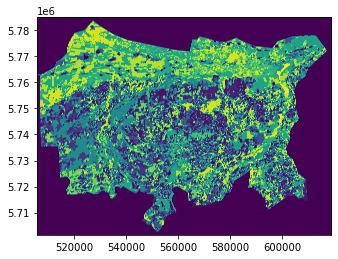

<AxesSubplot:>

In [7]:
input_path = '/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/polesia_burned_superclasses_all_touched_10m.tif'
polesia = rasterio.open(input_path)
show(polesia)

In [4]:
polesia_super = xr.open_rasterio(input_path, parse_coordinates=True)
polesia_super

<xarray.DataArray (band: 1, y: 8351, x: 11324)>
[94566724 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.785e+06 5.785e+06 5.785e+06 ... 5.701e+06 5.701e+06
  * x        (x) float64 5.056e+05 5.056e+05 5.056e+05 ... 6.188e+05 6.188e+05
Attributes:
    transform:      (10.0, 0.0, 505590.0, 0.0, -10.0, 5784980.0)
    crs:            +init=epsg:32635
    res:            (10.0, 10.0)
    is_tiled:       0
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [3]:
polesia_hab_path = '/gws/nopw/j04/ai4er/guided-team-challenge/2021/biodiversity/chernobyl_habitat_data/polesia_hab_10res.tif'
polesia_hab = xr.open_rasterio(polesia_hab_path, parse_coordinates=True)

def Eunis_to_superclasses(input_array):
    '''input xarray.DataArray with eunis classes and output dataarray with super classes
        but same coords and attributes as input'''

    new_class_1 = np.where((input_array == 21)|(input_array == 22)|(input_array == 23)
                             |(input_array == 24)|(input_array == 29)|(input_array == 30)|(input_array == 31)|
                             (input_array == 33), 
                             1, input_array)
    new_class_5 = np.where((input_array == 38)|(input_array == 43), 
                             5, new_class_1)
    new_class_6 = np.where((input_array == 35)|(input_array == 36)|(input_array == 37), 
                             6, new_class_5)
    new_class_7 = np.where((input_array == 25)|(input_array == 26)|(input_array == 27)|(input_array == 28), 
                             7, new_class_6)
    new_class_8 = np.where((input_array == 1), 
                             8, new_class_7)
    new_class_9 = np.where((input_array == 5), 
                             9, new_class_8)
    new_class_10 = np.where((input_array == 6), 
                             10, new_class_9)
    new_class_11 = np.where((input_array == 7)|(input_array == 8), 
                             11, new_class_10)
    new_class_12 = np.where((input_array == 9)|(input_array == 11), 
                             12, new_class_11)
    new_class_13 = np.where((input_array == 16)|(input_array == 17)|(input_array == 18)|(input_array == 32), 
                             13, new_class_12)
    new_class_14 = np.where((input_array == 19)|(input_array == 34), 
                             14, new_class_13)    
    new_class_15 = np.where((input_array == 39)|(input_array == 40), 
                             15, new_class_14)
    new_class_16 = np.where((input_array == 41), 
                             16, new_class_15)
    new_class_17 = np.where((input_array == 42), 
                             17, new_class_16)
    new_class_18 = np.where((input_array == 12)|(input_array == 13)|(input_array == 14)|(input_array == 15)|
                            (input_array == 20), 
                             18, new_class_17)
    new_class_19 = np.where((input_array == 10), 
                             19, new_class_18)
    
    output_array_final = xr.DataArray(data=new_class_19, coords=input_array.coords, attrs=input_array.attrs)
    
    return output_array_final

#super classes
polesia_sc = Eunis_to_superclasses(polesia_hab)
superclass_data=[]
superclass_vals = np.unique(polesia_sc)
for c in superclass_vals:
    superclass_data.append((polesia_sc == c).sum())

superclass_df = pd.DataFrame(superclass_data, index = superclass_vals, columns = ['pixel_count'])   

superclass_df.insert(superclass_df.shape[1], 'class_name', ['None', 'Pine forest', 'Reed beds', 'Undamaged bog',
                         'Dameged bog', 'Raised bog', 'Scrub woodland', 'Spruce', 'water', 'Mires',
                         'Beds of large species', 'Agriculture grass', 'Meadows',
                         'Swamp woods', 'Mixed forest', 'Felled forest', 'Cropland',
                         'Urban', 'Mixed forest 2', 'Herb stands'])

superclass_df

,pixel_count,class_name
0,33116245,None
1,11024156,Pine forest
2,975528,Reed beds
3,2404352,Undamaged bog
4,48436,Dameged bog
5,1457288,Raised bog
6,3700303,Scrub woodland
7,1048240,Spruce
8,26676,water
9,5744733,Mires


In [6]:
landcover_classes = superclass_df.index.tolist()

## 2. Analysis by Pylandstats

In [8]:
ls = pls.Landscape(input_path)

In [5]:
ls

### 2.1 Patch-level metrics

In [9]:
patch_metrics_df = ls.compute_patch_metrics_df()

In [11]:
patch_metrics_df

,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,0,369353.25,971560.0,2.630436,3.996545,1.125778,36.055513
1,0,81.21,6960.0,85.703731,1.922652,1.096705,686.804193
2,0,174.60,12400.0,71.019473,2.339623,1.118660,243.515913
3,0,91.32,5740.0,62.855891,1.494792,1.059246,981.121807
4,0,16.57,3700.0,223.295112,2.256098,1.136600,315.753068
...,...,...,...,...,...,...,...
12856,19,28.66,4340.0,151.430565,2.009259,1.112434,11667.908981
12857,19,46.41,5680.0,122.387417,2.072993,1.112583,246.981781
12858,19,28.41,6320.0,222.456881,2.953271,1.173072,147.648231


In [12]:
patch_metrics_df['class_val'].value_counts()

18    2095
1     1644
11    1567
6     1429
13    1053
9      859
14     776
15     709
5      510
12     422
3      396
8      301
17     294
7      250
16     180
0      131
2       83
19      79
10      48
4       35
Name: class_val, dtype: int64

In order to explore the size distribution of patches, the distribution of the logarithm of area for pine forest,reed beds and undamaged bog
classes are plotted as follows:

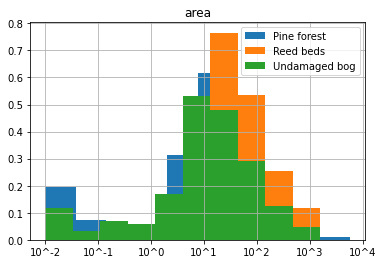

In [15]:
ax = patch_metrics_df[patch_metrics_df['class_val'] == 1].apply(np.log10).hist(
    column='area', label='Pine forest', density=True)
ax = patch_metrics_df[patch_metrics_df['class_val'] == 2].apply(np.log10).hist(
    column='area', ax=ax, label='Reed beds', density=True)
ax = patch_metrics_df[patch_metrics_df['class_val'] == 3].apply(np.log10).hist(
    column='area', ax=ax, label='Undamaged bog', density=True)

ax[0].get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '10^%d' % x))
ax[0].legend()

### 2.2 Class-level metrics

In [7]:
#When calculating the edge of the dataset, it will come error: '[None] not found in axis'
class_metrics = ['total_area', 'proportion_of_landscape', 'patch_density', 
                 'largest_patch_index', 'landscape_shape_index', 'effective_mesh_size']
class_metrics_df = ls.compute_class_metrics_df(metrics=class_metrics)
class_metrics_df

,total_area,proportion_of_landscape,patch_density,largest_patch_index,landscape_shape_index,effective_mesh_size
class_val,,,,,,
0,378153.55,39.988014,0.013853,39.057423,7.278803,144260.884222
1,110234.36,11.656781,0.173846,0.604812,87.392863,176.132221
2,9756.51,1.031706,0.008777,0.165137,16.520243,6.153483
3,24047.48,2.542911,0.041875,0.165843,34.804965,14.517715
4,484.64,0.051248,0.003701,0.010389,9.988662,0.021130
5,14581.89,1.541968,0.053930,0.113298,44.425911,3.870903
6,37005.65,3.913179,0.151110,0.104468,69.382536,5.714168
7,10482.23,1.108448,0.026436,0.070664,26.064453,1.831395
8,267.49,0.028286,0.031829,0.009142,15.006098,0.016190


<AxesSubplot:xlabel='class_val'>

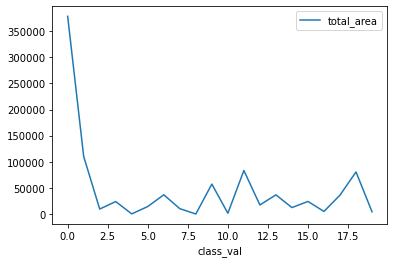

In [100]:
class_metrics_df.plot(y = 'total_area')

<AxesSubplot:title={'center':'The proportion of each class in the landscape'}, ylabel='proportion_of_landscape'>

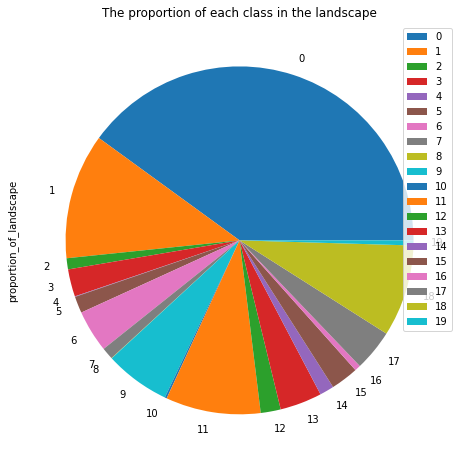

In [13]:
class_metrics_df.plot(y = 'proportion_of_landscape', kind='pie', figsize=(8,8), title='The proportion of each class in the landscape')

<AxesSubplot:title={'center':'Patch density of each class'}, xlabel='class_val'>

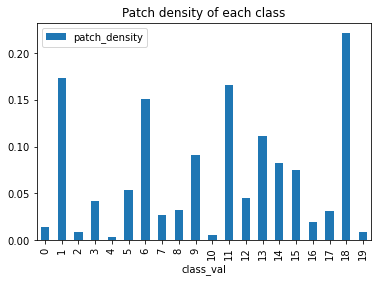

In [14]:
class_metrics_df.plot(y = 'patch_density', kind='bar', title='Patch density of each class')

<AxesSubplot:title={'center':'Landscape shape index of each class'}, xlabel='class_val'>

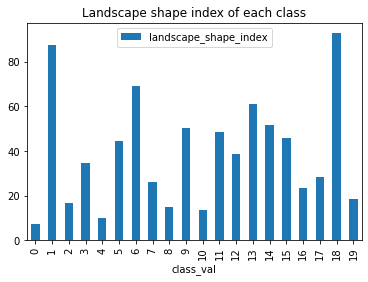

In [15]:
class_metrics_df.plot(y = 'landscape_shape_index', kind='bar', title='Landscape shape index of each class')

<AxesSubplot:title={'center':'Effective mesh size of each class'}, xlabel='class_val'>

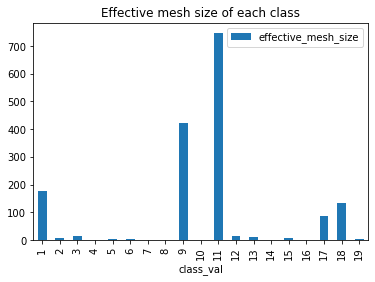

In [23]:
#Delete the class of no data in the dataframe
class_metrics_df1 = class_metrics_df.drop([0])
class_metrics_df1.plot(y = 'effective_mesh_size', kind='bar', title='Effective mesh size of each class')

The high values of effective mesh size indicate less fragmentation of the classes of agriculture grass and mires. Also, pine forests, mixed forest 2 (borad leaved forest) and herb stands have low level of fragmentaion in Polesia area. The rest classes seen=m to have high level of fragmentation. 

In [9]:
class_metrics2 = ['area_am', 'fractal_dimension_md', 'fractal_dimension_ra', 'fractal_dimension_sd',	'fractal_dimension_cv',	'euclidean_nearest_neighbor_mn', 'euclidean_nearest_neighbor_am', 'euclidean_nearest_neighbor_md',	'euclidean_nearest_neighbor_ra',	'euclidean_nearest_neighbor_sd',	'euclidean_nearest_neighbor_cv']
class_metrics_df2 = ls.compute_class_metrics_df(metrics=class_metrics2)
class_metrics_df2

,area_am,fractal_dimension_md,fractal_dimension_ra,fractal_dimension_sd,fractal_dimension_cv,euclidean_nearest_neighbor_mn,euclidean_nearest_neighbor_am,euclidean_nearest_neighbor_md,euclidean_nearest_neighbor_ra,euclidean_nearest_neighbor_sd,euclidean_nearest_neighbor_cv
class_val,,,,,,,,,,,
0,360760.310784,1.100671,0.192633,0.033918,3.073915,1520.530720,69.137783,1257.815567,7474.084334,1254.744307,82.520155
1,1510.985060,1.105321,0.384214,0.057265,5.176346,145.815347,75.317562,70.000000,2048.864423,210.068901,144.065015
2,596.437346,1.095102,0.173307,0.040995,3.734931,1058.471630,753.195981,390.128184,10435.926549,1863.377352,176.044147
3,570.909199,1.116268,0.238693,0.049003,4.401593,496.049163,289.995595,192.082439,4498.605980,689.912068,139.081389
4,41.229650,1.117958,0.283145,0.072736,6.494450,3842.208483,7440.880661,50.000000,19027.998897,5467.716131,142.306597
5,251.036468,1.105079,0.334621,0.048532,4.359993,652.000430,611.006581,351.062886,8468.792611,897.466122,137.648087
6,146.023697,1.096496,0.298216,0.041918,3.806993,313.654584,243.616549,180.000000,3973.219253,398.165955,126.944089
7,165.221588,1.084418,0.225185,0.037181,3.415633,899.736604,806.519488,485.464272,6480.861481,1094.329404,121.627752
8,57.235746,1.022230,0.392241,0.089683,8.372623,144.912043,9431.785342,22.360680,22115.629650,1345.121307,928.232932


### 2.3 Landscape metrics

In [92]:
landscape_metrics = ['total_area', 'patch_density', 'number_of_patches',
                 'effective_mesh_size', 'contagion', 'shannon_diversity_index']
landscape_metrics_df = ls.compute_landscape_metrics_df(metrics=landscape_metrics)

In [93]:
landscape_metrics_df

,total_area,patch_density,number_of_patches,effective_mesh_size,contagion,shannon_diversity_index
0,945667.24,1.359992,12861,145896.598856,62.414147,2.141935
